In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import h5py
import random
import numpy as np
import pandas as pd
from PIL import Image
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import normalize
from sklearn.model_selection import KFold
random.seed(42)
np.random.seed(42)

In [ ]:
# Set to True if we want to run the model with normalized images
# (smaller dataset)
image_normalization = False

In [ ]:
# Connect to Google Drive for files:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Put all data into one data frame:

In [ ]:
# def get_participant_data(p_id):
#   # Get image ids (change path if needed):
#   file_path = f'/content/drive/My Drive/Autumn 2023/BUSN 41916 Project/Data/ROIs/stim_lists/CSI0{p_id}_stim_lists.txt'
#   image_ids = np.loadtxt(file_path, dtype=str)
#   p_df = pd.DataFrame()
#   # Iterate over each trial number and concatenate into p_df:
#   for trial_num in ['1', '2', '3', '34', '4', '5']:
#     file_path = f'/content/drive/My Drive/Autumn 2023/BUSN 41916 Project/Data/ROIs/CSI{p_id}/h5/CSI{p_id}_ROIs_TR{trial_num}.h5'
#     trial_df = pd.DataFrame()
#     with h5py.File(file_path, 'r') as f:
#       # Get aggregate activation levels for each brain region:
#       for key in f.keys():
#         trial_df[key] = [image_response.mean() for image_response in f[key]]
#     trial_df.insert(0, 'image_id', image_ids)
#     trial_df['trial'] = trial_num
#     p_df = pd.concat([p_df, trial_df], ignore_index=True)
#   return p_df

# df = pd.DataFrame()
# for p_id in ['1', '2', '3', '4']:
#   p_df = get_participant_data(p_id)
#   p_df['participant'] = p_id
#   df = pd.concat([df, p_df], ignore_index=True)

# df.to_csv('/content/drive/My Drive/Autumn 2023/BUSN 41916 Project/Data/participant_responses.csv')

df = pd.read_csv('/content/drive/My Drive/BUSN 41916 Project/Data/participant_responses.csv')

In [ ]:
# Try to filter out to get one image per row:
y_col = ['LHEarlyVis', 'LHLOC', 'LHOPA', 'LHPPA', 'LHRSC', 'RHEarlyVis',
         'RHLOC', 'RHOPA', 'RHPPA', 'RHRSC']
# df = df.groupby('image_id')[y_col].mean().reset_index()
# df = df[(df['trial'] == 1) & (df['participant'] == 1)]

In [ ]:
print(df.shape)
df.head()

(113220, 14)


,Unnamed: 0,image_id,LHEarlyVis,LHLOC,LHOPA,LHPPA,LHRSC,RHEarlyVis,RHLOC,RHOPA,RHPPA,RHRSC,trial,participant
0,0,n01930112_19568.JPEG,-0.005209,0.006331,-0.003487,-0.004120,0.001741,-0.005559,0.006550,-0.000273,-0.006386,-0.000070,1,1
1,1,n03733281_29214.JPEG,0.001316,0.000388,-0.002388,-0.003867,0.005578,-0.007185,-0.005833,-0.001997,-0.001805,0.008767,1,1
2,2,n07695742_5848.JPEG,-0.005456,-0.006653,-0.001751,-0.004985,-0.008802,-0.006335,-0.004878,-0.001011,0.003150,0.001728,1,1
3,3,COCO_train2014_000000420713.jpg,-0.009369,-0.008381,-0.007291,-0.008370,-0.004953,-0.002245,-0.008092,-0.008549,-0.007834,-0.006843,1,1
4,4,COCO_train2014_000000488558.jpg,-0.004268,0.000220,0.001111,0.000180,0.012218,-0.002396,-0.000680,-0.000050,0.000656,0.008190,1,1


In [ ]:
df[y_col].describe().round(4)

,LHEarlyVis,LHLOC,LHOPA,LHPPA,LHRSC,RHEarlyVis,RHLOC,RHOPA,RHPPA,RHRSC
count,113220.0000,113220.0000,113220.0000,113220.0000,113220.0000,113220.0000,113220.0000,113220.0000,113220.0000,113220.0000
mean,0.0011,0.0007,0.0005,0.0009,0.0002,0.0011,0.0008,0.0009,0.0011,0.0007
std,0.0069,0.0053,0.0062,0.0076,0.0091,0.0071,0.0057,0.0070,0.0078,0.0080
min,-0.0333,-0.0320,-0.0426,-0.0392,-0.0580,-0.0385,-0.0298,-0.0456,-0.0361,-0.0400
25%,-0.0037,-0.0028,-0.0033,-0.0042,-0.0057,-0.0038,-0.0032,-0.0036,-0.0044,-0.0047
50%,0.0014,0.0008,0.0003,0.0007,-0.0001,0.0014,0.0010,0.0009,0.0009,0.0005
75%,0.0059,0.0041,0.0042,0.0059,0.0059,0.0060,0.0048,0.0054,0.0064,0.0058
max,0.0459,0.0323,0.0384,0.0538,0.0507,0.0489,0.0407,0.0548,0.0438,0.0449


Normalization of data:

(array([2.3000e+01, 5.8000e+02, 6.8480e+03, 3.1630e+04, 4.8102e+04,
        2.3751e+04, 2.1820e+03, 9.4000e+01, 8.0000e+00, 2.0000e+00]),
 array([-0.03327932, -0.02535785, -0.01743638, -0.00951492, -0.00159345,
         0.00632802,  0.01424949,  0.02217096,  0.03009243,  0.0380139 ,
         0.04593537]),
 <BarContainer object of 10 artists>)

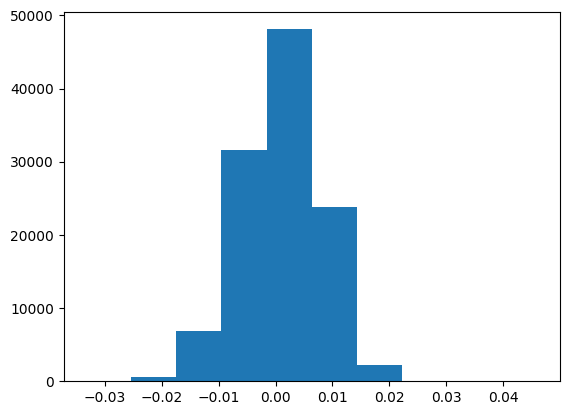

In [ ]:
plt.hist(df[y_col[0]])

(array([2.3000e+01, 5.8000e+02, 6.8480e+03, 3.1630e+04, 4.8102e+04,
        2.3751e+04, 2.1820e+03, 9.4000e+01, 8.0000e+00, 2.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

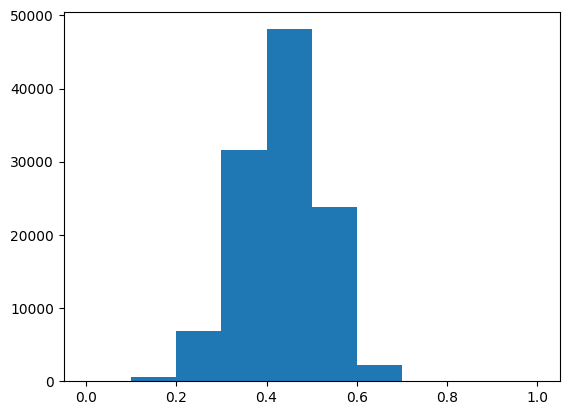

In [ ]:
# Transform y columns using min-max scaling:
scaler = MinMaxScaler()
y_col = ['LHEarlyVis', 'LHLOC', 'LHOPA', 'LHPPA', 'LHRSC', 'RHEarlyVis',
         'RHLOC', 'RHOPA', 'RHPPA', 'RHRSC']
for col in y_col:
  df[col] = scaler.fit_transform(df[[col]])
plt.hist(df[y_col[0]])

Load images:

In [ ]:
# Check which images exist:
parent_image_path = '/content/drive/My Drive/BUSN 41916 Project/Data/BOLD5000_Stimuli/Scene_Stimuli/Presented_Stimuli/'
folders = ['COCO', 'ImageNet', 'Scene']
# Create a dictionary that maps image ids to their path in Google Drive:
image_paths = {}
for image_id in df['image_id'].unique():
  # Search for image in the 3 different folders:
  for folder in folders:
    image_path = parent_image_path + f'{folder}/{image_id}'
    if os.path.exists(image_path):
      image_paths[image_id] = image_path
      break


In [ ]:
len(image_paths)

4916

In [ ]:
len(df['image_id'].unique())

5029

In [ ]:
# Find images that are not in the drive:
good_images = set(image_paths.keys())
bad_images = []
for image_id in df['image_id'].unique():
  if image_id not in good_images:
    bad_images.append(image_id)
len(bad_images)

113

Remove records in main data frame that use images that are unavailable:

In [ ]:
print('Shape before removal:', df.shape)
df = df[~df['image_id'].isin(bad_images)]
print('Shape after removal:', df.shape)

Shape before removal: (113220, 14)
Shape after removal: (105912, 14)


Convert images to numpy arrays and save in an .npz file (will take 10-20 mins, but only needs to run once):

In [ ]:
# image_arrays = {}
# i = 0
# image_normalization = False
# for image_id in df['image_id'].unique():
#   i += 1
#   # print(i)
#   image = Image.open(image_paths[image_id])
#   image_arrays[image_id] = np.array(image)
#   if i % 100 == 0:
#     print(i) # To monitor progress
# # Save to .npz file:
# file_path = '/content/drive/My Drive/Autumn 2023/BUSN 41916 Project/Data/stimuli_image_arrays.npz'
# np.savez(file_path, image_arrays, allow_pickle=True)

# # Save 1000 normalized images:
# image_arrays = {}
# ids = random.sample(list(df['image_id'].unique()), 1000)
# for i, image_id in enumerate(ids):
#   image = Image.open(image_paths[image_id])
#   image_arrays[image_id] = normalize(np.array(image), axis=1)
#   if i % 100 == 0:
#     print(i) # To monitor progress
# # Save to .npz file:
# file_path = '/content/drive/My Drive/Autumn 2023/BUSN 41916 Project/Data/stimuli_image_arrays_normalized_1000.npz'
# np.savez(file_path, image_arrays, allow_pickle=True)

Read images from .npz file:

In [ ]:
# Read the .npz file:
if image_normalization:
  file_path = '/content/drive/My Drive/BUSN 41916 Project/Data/stimuli_image_arrays_normalized_1000.npz'
else:
  file_path = '/content/drive/My Drive/BUSN 41916 Project/Data/stimuli_image_arrays.npz'
loaded_arrays = np.load(file_path, allow_pickle=True)
image_arrays = loaded_arrays['arr_0'].item()
# Try to clear out any unused data to save RAM:
del loaded_arrays
gc.collect()
print(len(image_arrays.keys()))

4916


All images are now stored as numpy arrays in the image_arrays dictionary. Each image is a value in the dictionary, where the key is the image's file name as it appears on Google Drive.

# CNN

## Data manipulation:

In [ ]:
# Edit data frame to remove rows that are not in the image dictionary:
print('Shape of df before removal:', df.shape)
df = df[df['image_id'].isin(image_arrays.keys())]
print('Shape of df after removal:', df.shape)

Shape of df before removal: (105912, 14)
Shape of df after removal: (105912, 14)


In [ ]:
# Check if all images are the same shape:
shapes = {}
for array in image_arrays.values():
  shapes[array.shape] = shapes.get(array.shape, 0) + 1
shapes

{(375, 375, 3): 4913, (348, 375, 3): 1, (375, 377, 3): 1, (375, 359, 3): 1}

In [ ]:
# Resize images to a standard shape:
target_shape = (375, 375, 3)
for key, image in list(image_arrays.items()):
  if image.shape != target_shape:
    tensor_image = tf.image.resize(image, target_shape[:2])
    # Convert values to int to save memory:
    tensor_image = tf.cast(tensor_image, dtype=tf.int32)
    image_arrays[key] = tensor_image.numpy()

In [ ]:
# Split into training and test sets:
#training_df, testing_df = train_test_split(df, test_size=0.2)
#y_col = ['LHEarlyVis', 'LHLOC', 'LHOPA', 'LHPPA', 'LHRSC', 'RHEarlyVis',
         #'RHLOC', 'RHOPA', 'RHPPA', 'RHRSC']
#y = training_df[y_col].to_numpy()
#image_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create a generator for loading images from the dictionary
def image_generator(df, image_dict, batch_size):
    image_datagen = ImageDataGenerator(rescale=1./255)
    while True:
        # Generate batch_size random indices
        indices = np.random.choice(len(df), size=batch_size, replace=False)

        # Get corresponding image titles and activations
        batch_image_titles = df['image_id'].iloc[indices]
        batch_activations = y.iloc[indices]

        # Check if all image titles are present in the image_dict
        if not all(title in image_dict for title in batch_image_titles):
            print("Skipping batch due to missing image in dictionary.")
            continue

        # Load images based on the batch_image_titles
        batch_images = [image_dict[title] for title in batch_image_titles]

        # Convert the list of images to numpy array
        batch_images = np.array(batch_images)

        # Apply data augmentation
        batch_images = image_datagen.flow(batch_images, shuffle=False).next()

        yield batch_images, {'output_layer': batch_activations}

### Only predicting one region (LHLOC):

In [ ]:
# y = df['LHLOC'].to_numpy()
# image_datagen = ImageDataGenerator(rescale=1./255)
# # Create a generator for loading images from the dictionary
# def image_generator(df, image_dict, image_datagen, batch_size):
#     while True:
#         # Generate batch_size random indices
#         indices = np.random.choice(len(df), size=batch_size, replace=False)

#         # Get corresponding image titles and activations
#         batch_image_titles = df['image_id'].iloc[indices]
#         batch_activations = y[indices]

#         # Load images based on the batch_image_titles
#         batch_images = [image_dict[title] for title in batch_image_titles]

#         # Convert the list of images to numpy array
#         batch_images = np.array(batch_images)

#         # Apply data augmentation
#         batch_images = image_datagen.flow(batch_images, shuffle=False).next()

#         yield batch_images, batch_activations

In [ ]:
# # Define your CNN model
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(375, 375, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1))  # Adjust the number of units based on your task

In [ ]:
# # Compile the model
# model.compile(optimizer='adam',
#               loss='mean_squared_error',  # Change the loss based on your task
#               metrics=['mae', 'mean_absolute_percentage_error'])  # Change metrics based on your task

In [ ]:
# # Specify the batch size
# batch_size = 10
# num_steps = 1000

# # Train the model using the image generator
# model.fit_generator(
#     image_generator(df, image_arrays, image_datagen, batch_size),
#     steps_per_epoch=num_steps,
#     epochs=5
# )

In [ ]:
# test_df = df.sample(1000)
# # Create a generator for the test set
# def test_generator(df, image_dict, image_datagen, batch_size):
#     while True:
#         # Use all samples without randomization for the test set
#         for start in range(0, len(df), batch_size):
#             end = min(start + batch_size, len(df))
#             batch_image_titles = df['image_id'].iloc[start:end]
#             batch_activations = df['LHLOC'].iloc[start:end]
#             batch_images = [image_dict[title] for title in batch_image_titles]
#             batch_images = np.array(batch_images)
#             batch_images = image_datagen.flow(batch_images, shuffle=False).next()

#             # Ensure batch_activations has the correct shape (batch_size,)
#             batch_activations = np.array(batch_activations)

#             yield batch_images, batch_activations


# # Evaluate the model on the test set
# test_batch_size = 10
# test_steps = len(test_df) // (test_batch_size * 100)

# # Use evaluate_generator for the generator-based evaluation
# evaluation = model.evaluate_generator(
#     test_generator(test_df, image_arrays, image_datagen, test_batch_size),
#     steps=test_steps
# )

# print(f"Test Loss: {evaluation[0]}")
# print(f"Test MAE: {evaluation[1]}")

### Train to predict all regions:

In [ ]:
def train_model(training_df, testing_df, y_col, image_arrays, batch_size, num_epochs, num_steps):
  # OG:
  # model = models.Sequential()
  # model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(375, 375, 3)))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  # model.add(layers.Flatten())
  # model.add(layers.Dense(64, activation='relu'))
  # # Add a single output layer for all brain regions
  # model.add(layers.Dense(len(y_col), activation='linear', name='output_layer'))

  # Best so far:
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(375, 375, 3), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  # Add a single output layer for all brain regions
  model.add(layers.Dense(len(y_col), activation='linear', name='output_layer'))

  # # Test:
  # model = models.Sequential()
  # model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(375, 375, 3)))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  # model.add(layers.Flatten())
  # model.add(layers.Dense(64, activation='relu'))
  # # Add a single output layer for all brain regions
  # model.add(layers.Dense(len(y_col), activation='linear', name='output_layer'))

  # Compile the model
  model.compile(optimizer='adagrad',
                loss='mean_squared_error',
                metrics=['mae',
                        'mean_absolute_percentage_error'])

  # Train the model using the image generator
  model.fit_generator(
      image_generator(training_df, image_arrays, batch_size),
      steps_per_epoch=num_steps,
      epochs=num_epochs
  )

  # Evaluate model:
  evaluation = model.evaluate_generator(
      image_generator(testing_df,
                      image_arrays,
                      batch_size),
      steps=num_steps
  )

  return model, evaluation

In [ ]:
def prediction_generator(df, image_dict, batch_size):
    image_datagen = ImageDataGenerator(rescale=1./255)
    num_iter = 0
    y = df[y_col].to_numpy()
    while True:
        # Generate batch_size random indices
        # indices = np.random.choice(len(df), size=batch_size, replace=False)
        indices = np.arange(num_iter * batch_size, num_iter * batch_size + batch_size)

        # Get corresponding image titles and activations
        batch_image_titles = df['image_id'].iloc[indices]
        batch_activations = y[indices]

        # Check if all image titles are present in the image_dict
        if not all(title in image_dict for title in batch_image_titles):
            print("Skipping batch due to missing image in dictionary.")
            continue

        # Load images based on the batch_image_titles
        batch_images = [image_dict[title] for title in batch_image_titles]

        # Convert the list of images to numpy array
        batch_images = np.array(batch_images)

        # Apply data augmentation
        batch_images = image_datagen.flow(batch_images, shuffle=False).next()

        # num_iter += 1
        num_iter = (num_iter + 1) % 100

        yield batch_images, {'output_layer': batch_activations}

def get_predictions(model, testing_df, image_arrays, batch_size, num_steps):
  '''
  '''
  # Define parameters for prediction:
  shuffled_testing_df = testing_df.sample(frac=1).reset_index(drop=True)
  generator = prediction_generator(shuffled_testing_df, image_arrays, batch_size)

  predictions = model.predict_generator(generator, steps=num_steps)
  # Get image labels associated with predictions:
  image_labels = np.array(shuffled_testing_df['image_id'].iloc[:(batch_size * num_steps)])
  predictions = pd.DataFrame(predictions)
  predictions.columns = y_col
  predictions['image_id'] = image_labels

  true_values = shuffled_testing_df[y_col + ['image_id']].iloc[:(batch_size * num_steps)]

  return predictions, true_values

In [ ]:
df = df[df.columns.drop('Unnamed: 0')]
df.head()

,image_id,LHEarlyVis,LHLOC,LHOPA,LHPPA,LHRSC,RHEarlyVis,RHLOC,RHOPA,RHPPA,RHRSC,trial,participant
0,n01930112_19568.JPEG,0.354363,0.596451,0.483172,0.377583,0.549397,0.376575,0.515765,0.451580,0.371800,0.470340,1,1
1,n03733281_29214.JPEG,0.436733,0.504045,0.496731,0.380299,0.584706,0.357960,0.340223,0.434418,0.429163,0.574347,1,1
2,n07695742_5848.JPEG,0.351240,0.394579,0.504595,0.368279,0.452379,0.367690,0.353765,0.444238,0.491205,0.491502,1,1
3,COCO_train2014_000000420713.jpg,0.301845,0.367703,0.436215,0.331886,0.487795,0.414520,0.308202,0.369207,0.353664,0.390626,1,1
4,COCO_train2014_000000488558.jpg,0.366239,0.501444,0.539929,0.423813,0.645803,0.412786,0.413269,0.453801,0.459980,0.567552,1,1


In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds)
batch_size = 10

#X = df['image_id'].to_numpy()
y_col = ['LHEarlyVis', 'LHLOC', 'LHOPA', 'LHPPA', 'LHRSC', 'RHEarlyVis',
            'RHLOC', 'RHOPA', 'RHPPA', 'RHRSC']
#y = df[y_col].to_numpy()

X = pd.DataFrame(df['image_id'])
y = pd.DataFrame(df[y_col])

image_datagen = ImageDataGenerator(rescale=1./255)

acc_score = []

for train_index, val_index in kf.split(X):
    #print(train_index, val_index)
    X_train, X_val = X[X.index.isin(train_index)], X[X.index.isin(val_index)]
    y_train, y_val = y[y.index.isin(train_index)], y[y.index.isin(val_index)]
    print(X_val)

    # Generate batch_size random indices
    indices = np.random.choice(len(X_val), size=batch_size, replace=False)

    # Get corresponding image titles and activations
    batch_image_titles = X_val['image_id'].iloc[indices]
    batch_activations = y_val.iloc[indices]

                              image_id
0                 n01930112_19568.JPEG
1                 n03733281_29214.JPEG
2                  n07695742_5848.JPEG
3      COCO_train2014_000000420713.jpg
4      COCO_train2014_000000488558.jpg
...                                ...
21178  COCO_train2014_000000363084.jpg
21179  COCO_train2014_000000404007.jpg
21180  COCO_train2014_000000195027.jpg
21181  COCO_train2014_000000347133.jpg
21182                    driveway6.jpg

[19823 rows x 1 columns]
                              image_id
21183              n01698640_3315.JPEG
21184              n02110958_4869.JPEG
21186                      highway.jpg
21187             sculpturegarden1.jpg
21188  COCO_train2014_000000412200.jpg
...                                ...
42361                        pond3.jpg
42362  COCO_train2014_000000219735.jpg
42363              n04509417_4411.JPEG
42364  COCO_train2014_000000391615.jpg
42365              n02096294_4267.JPEG

[19821 rows x 1 columns]
            

In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds)

#X = df['image_id'].to_numpy()
y_col = ['LHEarlyVis', 'LHLOC', 'LHOPA', 'LHPPA', 'LHRSC', 'RHEarlyVis',
            'RHLOC', 'RHOPA', 'RHPPA', 'RHRSC']
#y = df[y_col].to_numpy()
#X = pd.DataFrame(df['image_id'])
#y = pd.DataFrame(df[y_col])

mae_cols_score = []
mae_score = []

for train_index, val_index in kf.split(X):
    #X_train, X_val = X[X.index.isin(train_index)], X[X.index.isin(val_index)]
    #y_train, y_val = y[y.index.isin(train_index)], y[y.index.isin(val_index)]
    training_df, testing_df = df[df.index.isin(train_index)], df[df.index.isin(val_index)]

    image_datagen = ImageDataGenerator(rescale=1./255)

    # Train new model:
    batch_size = 10
    num_steps = len(X_train) // batch_size
    num_epochs = 3

    model, evaluation = train_model(training_df,
                                    testing_df,
                                    y_col,
                                    image_arrays,
                                    batch_size,
                                    num_epochs,
                                    num_steps)
    print('Loss:', evaluation[0])
    print('MAE:', evaluation[1])
    print('Mean Absolute Percentage Error:', evaluation[2])

    num_steps = 20

    predictions, true_values = get_predictions(model,
                                           testing_df,
                                           image_arrays,
                                           batch_size,
                                           num_steps)

    for col in y_col:
        print(f'MAE for {col}:')
        y_true = true_values[col]
        y_pred = predictions[col]
        mae_col = mean_absolute_error(y_true, y_pred)
        mae_cols_score.append([col, mae_col])
        print(mae_col)

    mae_score.append(mean_absolute_error(predictions[predictions.columns.drop('image_id')], true_values[true_values.columns.drop('image_id')]))

avg_mae_score = sum(mae_score)/k_folds
print(avg_mae_score)

Epoch 1/3


<ipython-input-28-c454ee2a6831>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


7927/7927 [==============================] - 420s 53ms/step - loss: 0.0093 - mae: 0.0755 - mean_absolute_percentage_error: 17.1879
Epoch 2/3
7927/7927 [==============================] - 427s 54ms/step - loss: 0.0076 - mae: 0.0691 - mean_absolute_percentage_error: 1194.7006
Epoch 3/3
7927/7927 [==============================] - 425s 54ms/step - loss: 0.0075 - mae: 0.0686 - mean_absolute_percentage_error: 2289.5840


<ipython-input-28-c454ee2a6831>:58: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = model.evaluate_generator(


Loss: 0.005746144335716963
MAE: 0.06072453409433365
Mean Absolute Percentage Error: 13.57883358001709


<ipython-input-29-46c9f8d63e0a>:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, steps=num_steps)


MAE for LHEarlyVis:
0.06369324224371846
MAE for LHLOC:
0.059192540426129564
MAE for LHOPA:
0.051576964394372746
MAE for LHPPA:
0.05465051468068971
MAE for LHRSC:
0.052263713666375985
MAE for RHEarlyVis:
0.067800455688787
MAE for RHLOC:
0.07012693179079064
MAE for RHOPA:
0.03974233020284443
MAE for RHPPA:
0.06776866622662377
MAE for RHRSC:
0.07275211422198603
Epoch 1/3


<ipython-input-28-c454ee2a6831>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


7927/7927 [==============================] - 426s 54ms/step - loss: 0.0091 - mae: 0.0746 - mean_absolute_percentage_error: 4136.9717
Epoch 2/3
7927/7927 [==============================] - 425s 54ms/step - loss: 0.0076 - mae: 0.0692 - mean_absolute_percentage_error: 4531.2803
Epoch 3/3
7927/7927 [==============================] - 425s 54ms/step - loss: 0.0075 - mae: 0.0686 - mean_absolute_percentage_error: 1074.9337


<ipython-input-28-c454ee2a6831>:58: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = model.evaluate_generator(


Loss: 0.005747325252741575
MAE: 0.06066640466451645
Mean Absolute Percentage Error: 13.584091186523438


<ipython-input-29-46c9f8d63e0a>:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, steps=num_steps)


MAE for LHEarlyVis:
0.07843343348396971
MAE for LHLOC:
0.07903680949220171
MAE for LHOPA:
0.07645409711303776
MAE for LHPPA:
0.07105028444712705
MAE for LHRSC:
0.07415595996579029
MAE for RHEarlyVis:
0.0752098013501332
MAE for RHLOC:
0.07257309907951273
MAE for RHOPA:
0.05863428275303582
MAE for RHPPA:
0.07849075373711197
MAE for RHRSC:
0.0630237626465018
Epoch 1/3


<ipython-input-28-c454ee2a6831>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


7927/7927 [==============================] - 424s 53ms/step - loss: 0.0090 - mae: 0.0748 - mean_absolute_percentage_error: 1201.6709
Epoch 2/3
7927/7927 [==============================] - 422s 53ms/step - loss: 0.0077 - mae: 0.0694 - mean_absolute_percentage_error: 6297.9219
Epoch 3/3
7927/7927 [==============================] - 423s 53ms/step - loss: 0.0075 - mae: 0.0687 - mean_absolute_percentage_error: 1647.4735


<ipython-input-28-c454ee2a6831>:58: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = model.evaluate_generator(


Loss: 0.006063627544790506
MAE: 0.06217150017619133
Mean Absolute Percentage Error: 13.439871788024902


<ipython-input-29-46c9f8d63e0a>:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, steps=num_steps)


MAE for LHEarlyVis:
0.08969951286040238
MAE for LHLOC:
0.08715393658359107
MAE for LHOPA:
0.07924913557852897
MAE for LHPPA:
0.09686003747909808
MAE for LHRSC:
0.07637102756600987
MAE for RHEarlyVis:
0.08439622553624827
MAE for RHLOC:
0.07241598941316925
MAE for RHOPA:
0.08308226654713743
MAE for RHPPA:
0.1036288744223122
MAE for RHRSC:
0.06072194913636734
Epoch 1/3


<ipython-input-28-c454ee2a6831>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


7927/7927 [==============================] - 425s 53ms/step - loss: 0.0089 - mae: 0.0739 - mean_absolute_percentage_error: 4225.0952
Epoch 2/3
7927/7927 [==============================] - 424s 54ms/step - loss: 0.0075 - mae: 0.0687 - mean_absolute_percentage_error: 2905.3555
Epoch 3/3
7927/7927 [==============================] - 423s 53ms/step - loss: 0.0075 - mae: 0.0684 - mean_absolute_percentage_error: 605.8936


<ipython-input-28-c454ee2a6831>:58: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = model.evaluate_generator(


Loss: 0.005750027485191822
MAE: 0.06069878116250038
Mean Absolute Percentage Error: 13.729533195495605


<ipython-input-29-46c9f8d63e0a>:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, steps=num_steps)


MAE for LHEarlyVis:
0.06828131531115716
MAE for LHLOC:
0.052530591006516685
MAE for LHOPA:
0.04587896633774811
MAE for LHPPA:
0.06255124914230387
MAE for LHRSC:
0.06682529690110937
MAE for RHEarlyVis:
0.055781900012896235
MAE for RHLOC:
0.06281541533891334
MAE for RHOPA:
0.054671855632962535
MAE for RHPPA:
0.08119929665006928
MAE for RHRSC:
0.08657098292944196
Epoch 1/3


<ipython-input-28-c454ee2a6831>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


7927/7927 [==============================] - 427s 54ms/step - loss: 0.0090 - mae: 0.0745 - mean_absolute_percentage_error: 6644.6445
Epoch 2/3
7927/7927 [==============================] - 427s 54ms/step - loss: 0.0075 - mae: 0.0685 - mean_absolute_percentage_error: 611.6876
Epoch 3/3
7927/7927 [==============================] - 426s 54ms/step - loss: 0.0074 - mae: 0.0685 - mean_absolute_percentage_error: 1729.7655


<ipython-input-28-c454ee2a6831>:58: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = model.evaluate_generator(


Loss: 0.005974752828478813
MAE: 0.06184818968176842
Mean Absolute Percentage Error: 13.54625129699707


<ipython-input-29-46c9f8d63e0a>:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, steps=num_steps)


MAE for LHEarlyVis:
0.06401979500788686
MAE for LHLOC:
0.05335259522241872
MAE for LHOPA:
0.04231232923205946
MAE for LHPPA:
0.04417999091362401
MAE for LHRSC:
0.057584825414579266
MAE for RHEarlyVis:
0.05665665679695737
MAE for RHLOC:
0.06146742562592218
MAE for RHOPA:
0.044499626720956656
MAE for RHPPA:
0.07345198369616991
MAE for RHRSC:
0.07756145873233762
0.0674480453871927


In [ ]:
mean_absolute_error(predictions[predictions.columns.drop('image_id')], true_values[true_values.columns.drop('image_id')])

0.057276212748536406

In [ ]:
sum(mae_score)/len(mae_score)

0.0674480453871927

In [ ]:
LHEarlyVis = []
LHLOC = []
LHOPA = []
LHPPA = []
LHRSC = []
RHEarlyVis = []
RHLOC = []
RHOPA = []
RHPPA = []
RHRSC = []

for i in range(len(mae_cols_score)):
    if i % 10 == 0:
        LHEarlyVis.append(mae_cols_score[i][1])
    elif i % 10 == 1:
        LHLOC.append(mae_cols_score[i][1])
    elif i % 10 == 2:
        LHOPA.append(mae_cols_score[i][1])
    elif i % 10 == 3:
        LHPPA.append(mae_cols_score[i][1])
    elif i % 10 == 4:
        LHRSC.append(mae_cols_score[i][1])
    elif i % 10 == 5:
        RHEarlyVis.append(mae_cols_score[i][1])
    elif i % 10 == 6:
        RHLOC.append(mae_cols_score[i][1])
    elif i % 10 == 7:
        RHOPA.append(mae_cols_score[i][1])
    elif i % 10 == 8:
        RHPPA.append(mae_cols_score[i][1])
    else:
        RHRSC.append(mae_cols_score[i][1])

In [ ]:
for maes in [LHEarlyVis, LHLOC, LHOPA, LHPPA, LHRSC, RHEarlyVis, RHLOC, RHOPA, RHPPA, RHRSC]:
    avg_mae_col = sum(maes)/len(maes)
    print(f"Average of {maes}: ", round(avg_mae_col,3))

Average of [0.06369324224371846, 0.07843343348396971, 0.08969951286040238, 0.06828131531115716, 0.06401979500788686]:  0.073
Average of [0.059192540426129564, 0.07903680949220171, 0.08715393658359107, 0.052530591006516685, 0.05335259522241872]:  0.066
Average of [0.051576964394372746, 0.07645409711303776, 0.07924913557852897, 0.04587896633774811, 0.04231232923205946]:  0.059
Average of [0.05465051468068971, 0.07105028444712705, 0.09686003747909808, 0.06255124914230387, 0.04417999091362401]:  0.066
Average of [0.052263713666375985, 0.07415595996579029, 0.07637102756600987, 0.06682529690110937, 0.057584825414579266]:  0.065
Average of [0.067800455688787, 0.0752098013501332, 0.08439622553624827, 0.055781900012896235, 0.05665665679695737]:  0.068
Average of [0.07012693179079064, 0.07257309907951273, 0.07241598941316925, 0.06281541533891334, 0.06146742562592218]:  0.068
Average of [0.03974233020284443, 0.05863428275303582, 0.08308226654713743, 0.054671855632962535, 0.044499626720956656]:  0

In [ ]:
mae_cols_score

[['LHEarlyVis', 0.06369324224371846],
 ['LHLOC', 0.059192540426129564],
 ['LHOPA', 0.051576964394372746],
 ['LHPPA', 0.05465051468068971],
 ['LHRSC', 0.052263713666375985],
 ['RHEarlyVis', 0.067800455688787],
 ['RHLOC', 0.07012693179079064],
 ['RHOPA', 0.03974233020284443],
 ['RHPPA', 0.06776866622662377],
 ['RHRSC', 0.07275211422198603],
 ['LHEarlyVis', 0.07843343348396971],
 ['LHLOC', 0.07903680949220171],
 ['LHOPA', 0.07645409711303776],
 ['LHPPA', 0.07105028444712705],
 ['LHRSC', 0.07415595996579029],
 ['RHEarlyVis', 0.0752098013501332],
 ['RHLOC', 0.07257309907951273],
 ['RHOPA', 0.05863428275303582],
 ['RHPPA', 0.07849075373711197],
 ['RHRSC', 0.0630237626465018],
 ['LHEarlyVis', 0.08969951286040238],
 ['LHLOC', 0.08715393658359107],
 ['LHOPA', 0.07924913557852897],
 ['LHPPA', 0.09686003747909808],
 ['LHRSC', 0.07637102756600987],
 ['RHEarlyVis', 0.08439622553624827],
 ['RHLOC', 0.07241598941316925],
 ['RHOPA', 0.08308226654713743],
 ['RHPPA', 0.1036288744223122],
 ['RHRSC', 0.06

In [ ]:
# Load model:
# path = '/content/drive/My Drive/Autumn 2023/BUSN 41916 Project/Models/10_8472_2_cnn.keras'
# model = models.load_model(path)

batch_size = 10
num_steps = 20

predictions, true_values = get_predictions(model,
                                           testing_df,
                                           image_arrays,
                                           batch_size,
                                           num_steps)

<ipython-input-30-46c9f8d63e0a>:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, steps=num_steps)


In [ ]:
predictions.head()

,LHEarlyVis,LHLOC,LHOPA,LHPPA,LHRSC,RHEarlyVis,RHLOC,RHOPA,RHPPA,RHRSC,image_id
0,0.427330,0.505001,0.524936,0.426412,0.521520,0.445977,0.435590,0.457305,0.464008,0.470628,n01980166_1563.JPEG
1,0.436857,0.505759,0.530116,0.438486,0.530707,0.459892,0.431225,0.464230,0.466663,0.482986,COCO_train2014_000000468771.jpg
2,0.414751,0.489914,0.509013,0.410024,0.503939,0.436890,0.421939,0.444152,0.444964,0.443688,n07753592_10770.JPEG
3,0.431773,0.500296,0.525067,0.433897,0.521726,0.449688,0.430980,0.449379,0.469540,0.468321,COCO_train2014_000000509269.jpg
4,0.419962,0.507471,0.527737,0.422263,0.524364,0.441531,0.431916,0.458983,0.455853,0.463756,COCO_train2014_000000356810.jpg


In [ ]:
predictions['LHEarlyVis'].value_counts()

0.459202    2
0.427576    2
0.438087    1
0.426202    1
0.410849    1
           ..
0.441421    1
0.443768    1
0.446810    1
0.433830    1
0.441853    1
Name: LHEarlyVis, Length: 198, dtype: int64

Compare predictions to true values:

In [ ]:
for col in y_col:
  print(f'MAE for {col}:')
  y_true = true_values[col]
  y_pred = predictions[col]
  print(mean_absolute_error(y_true, y_pred))

MAE for LHEarlyVis:
0.06937356121689922
MAE for LHLOC:
0.06472685821006109
MAE for LHOPA:
0.057051206546331876
MAE for LHPPA:
0.057971442891369164
MAE for LHRSC:
0.06160405963162953
MAE for RHEarlyVis:
0.0662811959012723
MAE for RHLOC:
0.06441355195412665
MAE for RHOPA:
0.05520855596839651
MAE for RHPPA:
0.07325104937876158
MAE for RHRSC:
0.06922673168760837


Plot predictions against true values:

In [ ]:
for col in y_col:
  print(f'R-squared for {col}:')
  y_true = true_values[col]
  y_pred = predictions[col]
  print(r2_score(y_true, y_pred))

R-squared for LHEarlyVis:
-0.07745461566642531
R-squared for LHLOC:
-0.11123966880929981
R-squared for LHOPA:
-0.18985613494377707
R-squared for LHPPA:
-0.05927408384199628
R-squared for LHRSC:
-0.005525244471908275
R-squared for RHEarlyVis:
-0.10454361563965575
R-squared for RHLOC:
-0.06440816632101609
R-squared for RHOPA:
-0.08944823716537886
R-squared for RHPPA:
-0.10390542955165794
R-squared for RHRSC:
-0.0092709028705531


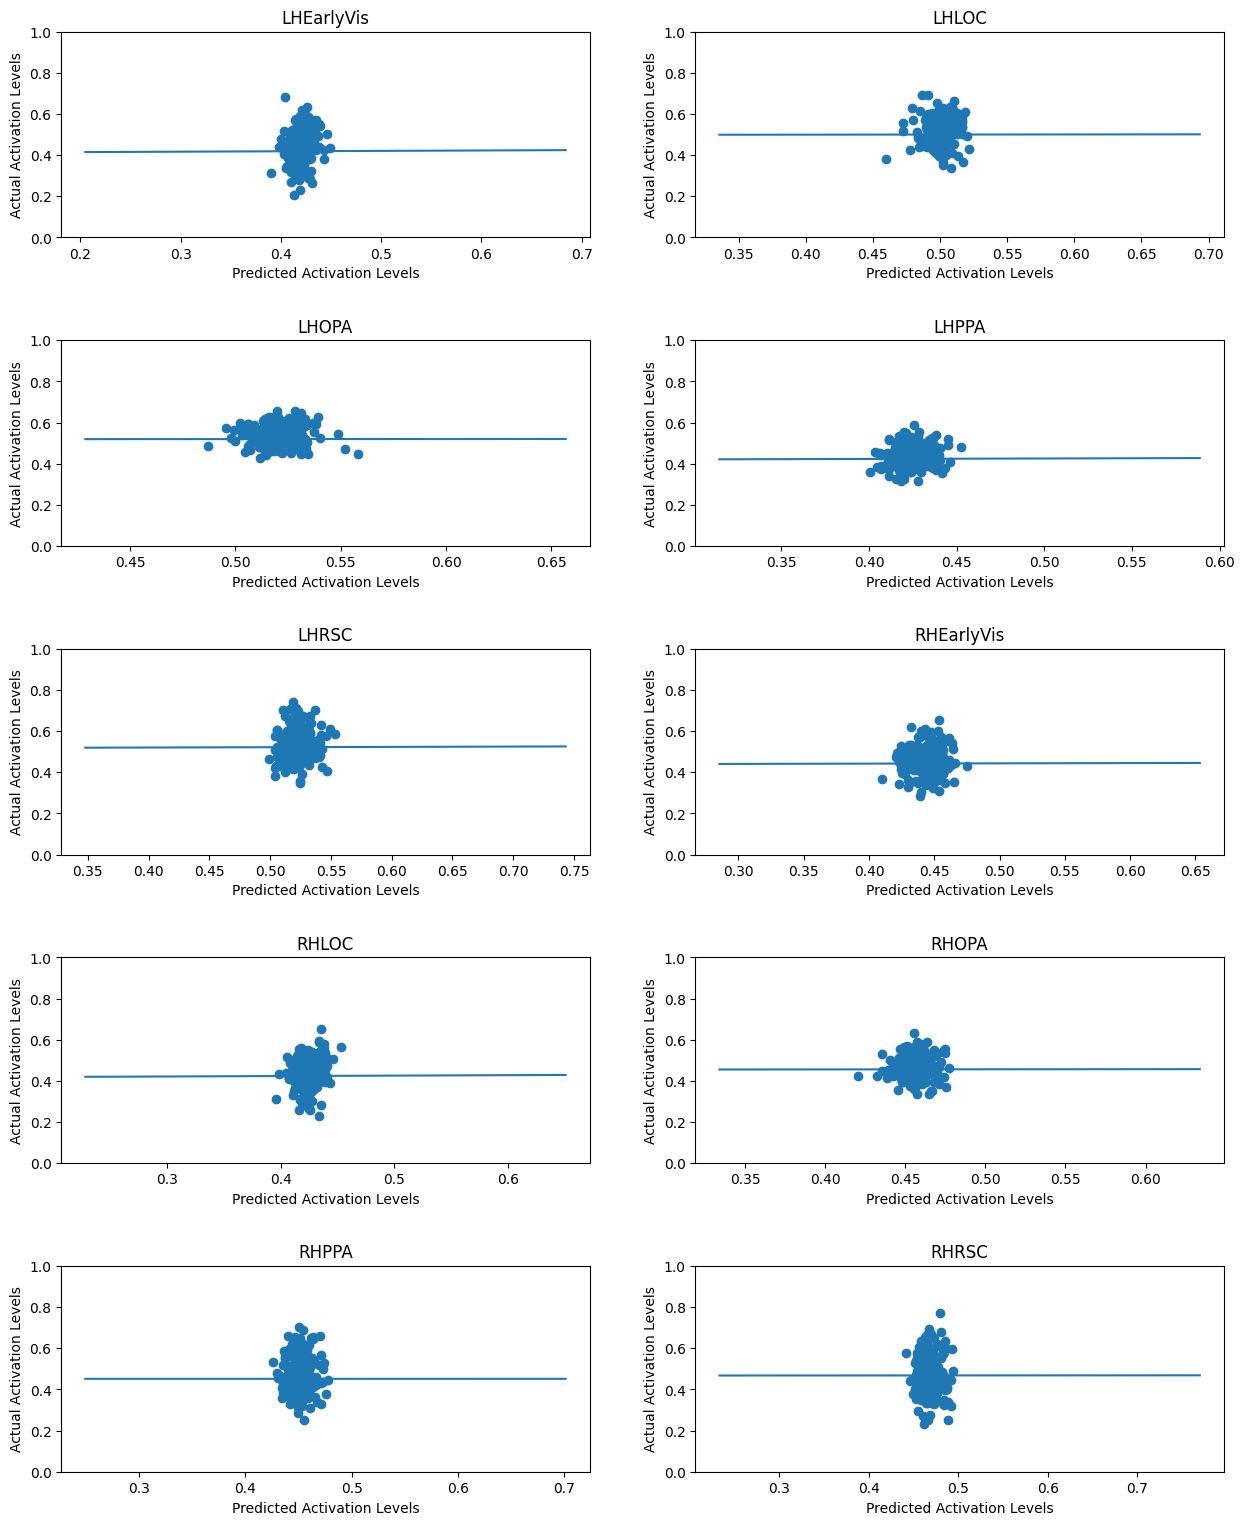

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))
x = 0
for i in range(5):
  for j in range(2):
    axs[i][j].scatter(predictions[y_col[x]], true_values[y_col[x]])
    axs[i][j].set_title(f'{y_col[x]}')
    axs[i][j].set_ylabel('Actual Activation Levels')
    axs[i][j].set_xlabel('Predicted Activation Levels')
    # axs[i][j].set_xlim(left=0, right=1)
    axs[i][j].set_ylim(bottom=0, top=1)
    axs[i][j].plot(np.unique(true_values[y_col[x]]), np.poly1d(np.polyfit(true_values[y_col[x]], predictions[y_col[x]], 1))(np.unique(true_values[y_col[x]])))
    #plt.text(0.6, 0.5, 'R-squared = %0.2f' % r2_score(true_values[y_col[x]], predictions[y_col[x]]))
    x += 1

plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.5)

In [ ]:
gc.collect()

65

# Data exploration

In [ ]:
df.shape

(105912, 14)

In [ ]:
filtered = df[df['participant'] == 3]
filtered['trial'].value_counts()

1     4916
2     4916
3     4916
34    4916
4     4916
5     4916
Name: trial, dtype: int64